In [10]:
from confluent_kafka import Consumer, KafkaException
from textblob import TextBlob
from pymongo import MongoClient
import json

# Create a Kafka consumer
conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'youtube_group',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

# Subscribe to Kafka topic
consumer.subscribe(['YouTubeC'])

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['youtube']
collection = db['comments']

count = 0
empty_counts = 0
max_empty_counts = 5  # Exit loop if there are no new messages for 5 consecutive polls

try:
    while True:
        # Exit loop if 1000 comments have been processed, or if there are no new messages for 5 consecutive polls
        if count >= 1000 or empty_counts >= max_empty_counts:
            break

        msg = consumer.poll(1.0)  # Poll for messages

        if msg is None:
            empty_counts += 1
            continue
        else:
            empty_counts = 0  # Reset counter if there's a new message

        if msg.error():
            raise KafkaException(msg.error())
        else:
            print('Received message: {}'.format(msg.value().decode('utf-8')))

            # Extract comments from the message value
            video_data = json.loads(msg.value().decode('utf-8'))
            comments = video_data.get('comments', [])

            for comment in comments:
                # Create a TextBlob object
                blob = TextBlob(comment)

                sentiment_result = {
                    'video_id': msg.key(),  # Get video ID from message key
                    'num_views': video_data['num_views'],
                    'num_likes': video_data['num_likes'],
                    'video_length': video_data['video_length'],
                    'comment': comment,
                    'sentiment': {
                        'polarity': blob.sentiment.polarity,
                        'subjectivity': blob.sentiment.subjectivity,
                    }
                }

                # Insert comment data into the collection
                collection.insert_one(sentiment_result)
                count += 1

finally:
    consumer.close()


Correlation between number of views and sentiment polarity: -0.02561451416015023
Correlation between number of likes and sentiment polarity: -0.053758670425380274
Correlation between video length and sentiment polarity: 0.126688519007472


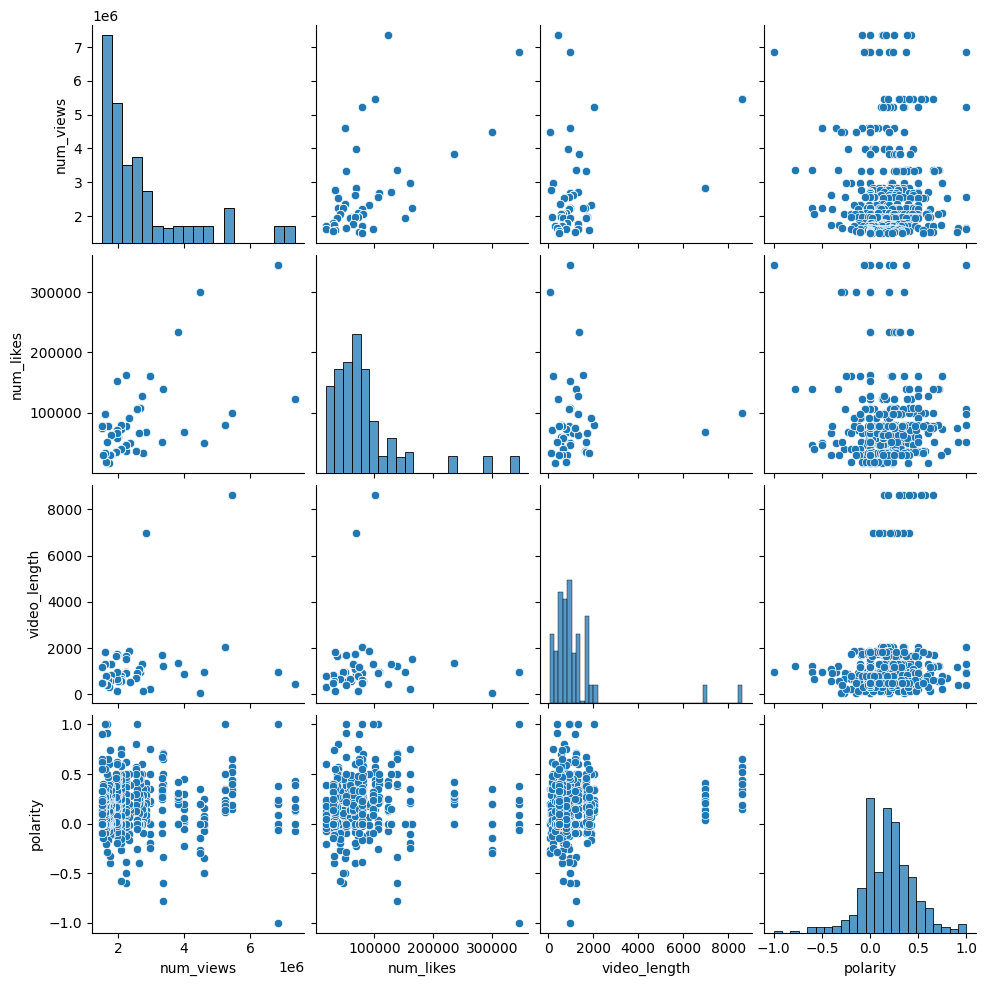

In [17]:
import pandas as pd
import seaborn as sns
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['youtube']
collection = db['comments']

# Retrieve data from MongoDB
data = list(collection.find({}))

# Convert data into pandas DataFrame
df = pd.DataFrame(data)
df['polarity'] = df['sentiment'].apply(lambda x: x['polarity'])
df['subjectivity'] = df['sentiment'].apply(lambda x: x['subjectivity'])

# Convert string fields to float type
df['num_views'] = df['num_views'].astype(float)
df['num_likes'] = df['num_likes'].astype(float)
df['video_length'] = df['video_length'].astype(float)

# Calculate correlations between num_views, num_likes, video_length, and polarity
correlations = {
    'views_polarity': df['num_views'].corr(df['polarity']),
    'likes_polarity': df['num_likes'].corr(df['polarity']),
    'length_polarity': df['video_length'].corr(df['polarity']),
}

print(f"Correlation between number of views and sentiment polarity: {correlations['views_polarity']}")
print(f"Correlation between number of likes and sentiment polarity: {correlations['likes_polarity']}")
print(f"Correlation between video length and sentiment polarity: {correlations['length_polarity']}")

# Plot scatter plots between num_views, num_likes, video_length, and polarity
sns.pairplot(df, vars=['num_views', 'num_likes', 'video_length', 'polarity'])
